## 2. Load Data and Train a model then save the model's weight

**Used Hyperparameter**<br>
Without Data Augmentation<br>


-----------------------<br>
Level: 2,3,4 images <br>
Number of train,val,test: 9, 3, 3 <br>
train's stride : 299 <br>
test's stride: 299 <br>
tissue percent min: 50 <br>


In [1]:
import numpy as np
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from matplotlib.patches import Rectangle
import re
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
import os

# Initialization
lowest_level = 2
highest_level = 4
train_val_stride = 299
test_stride = 299
tissue_p_min = 50

dir = '/content/drive/MyDrive/Applied_Deep_Learning_Project/'
current_dir = 'Lev_234_split_933_stride_200_pmin_50'
saving_dir = os.path.join(dir,current_dir)
saving_dir

'/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_234_split_933_stride_200_pmin_50'

In [3]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
print()

# Check TensorFlow version
import tensorflow as tf 
print("TF version: ", tf.__version__)
print()

# Check which GPU with available RAM
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Mounted at /content/drive

TF version:  2.4.0

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla V100-SXM2-16GB, 418.67, 16130 MiB


In [4]:
zoom1_train = np.load(os.path.join(saving_dir,'zoom1_train.npy'))
zoom2_train = np.load(os.path.join(saving_dir,'zoom2_train.npy'))
zoom3_train = np.load(os.path.join(saving_dir,'zoom3_train.npy'))
label_train = np.load(os.path.join(saving_dir,'label_train.npy'))

zoom1_valid = np.load(os.path.join(saving_dir,'zoom1_valid.npy'))
zoom2_valid = np.load(os.path.join(saving_dir,'zoom2_valid.npy'))
zoom3_valid = np.load(os.path.join(saving_dir,'zoom3_valid.npy'))
label_valid = np.load(os.path.join(saving_dir,'label_valid.npy'))

X_train = [zoom1_train, zoom2_train, zoom3_train]
X_valid = [zoom1_valid, zoom2_valid, zoom3_valid]
BATCH_SIZE = 32

In [5]:
def create_inceptionv3(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  base_model.trainable = False
  return base_model


def create_inceptionv3_fine_tune(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  
  base_model.trainable = True
  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base InceptionV3 model: ", len(base_model.layers))
  # Fine-tune from this layer onwards
  fine_tune_at = 100
  print("Start fine tuning at layer: ", fine_tune_at)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  return base_model


def create_global_avg_layer():
  return tf.keras.layers.GlobalAveragePooling2D()


def create_dense_layer():
  return tf.keras.layers.Dense(1024, activation='relu')

In [6]:
# Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two(fine_tune):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
    base_model_3 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()
    base_model_3 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_3 = tf.keras.Sequential([
    base_model_3,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
  input3 = Input(shape=(299,299,3))
    
  model_concat = concatenate([model_1(input1) ,model_2(input2),model_3(input3)])
  model = Dense(1024, activation='relu')(model_concat)
  model = Dense(1, activation='sigmoid')(model)
  model_final = Model(inputs=[input1,input2,input3],outputs=model)

  return model_final

In [7]:
# A plotting function you can reuse
def plot(history):
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  # added new version for better layout in visualization (for fun)
  fig, ax = plt.subplots(1,2, figsize = (14,5))
  ax[0].set_title('Training and validation accuracy')
  ax[0].plot(epochs, acc, color='blue', label='Train')
  ax[0].plot(epochs, val_acc, color='orange', label='Val')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  ax[1].set_title('Training and validation loss')
  ax[1].plot(epochs, loss, color='blue', label='Train')
  ax[1].plot(epochs, val_loss, color='orange', label='Val')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

### Version a: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_4[0][0]                    
_____________________________

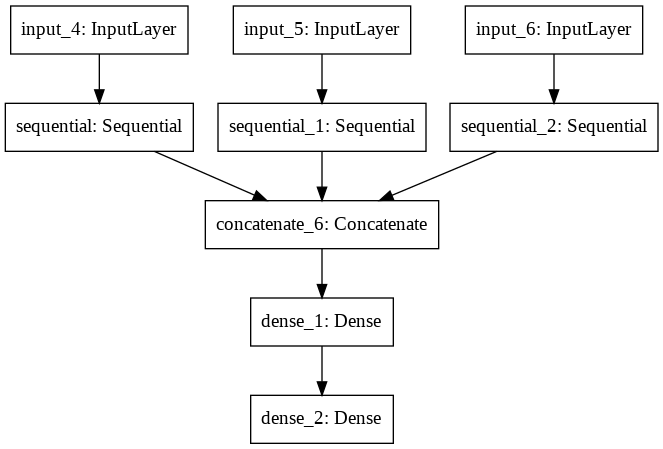

In [9]:
mdl_9_3_wo_ft_wo_da = create_model_keras_inputs_two(fine_tune = False)
mdl_9_3_wo_ft_wo_da.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da))

Epoch 1/10
184/184 [==============================] - 63s 259ms/step - loss: 8.6951 - accuracy: 0.7731 - val_loss: 0.7920 - val_accuracy: 0.6263
Epoch 2/10
184/184 [==============================] - 44s 237ms/step - loss: 0.2719 - accuracy: 0.8938 - val_loss: 1.5811 - val_accuracy: 0.5878
Epoch 3/10
184/184 [==============================] - 43s 236ms/step - loss: 0.1951 - accuracy: 0.9245 - val_loss: 1.4677 - val_accuracy: 0.5971
Epoch 4/10
184/184 [==============================] - 43s 237ms/step - loss: 0.1734 - accuracy: 0.9298 - val_loss: 1.8306 - val_accuracy: 0.5971
Epoch 5/10
184/184 [==============================] - 43s 236ms/step - loss: 0.1622 - accuracy: 0.9353 - val_loss: 1.4202 - val_accuracy: 0.5891
Epoch 6/10
184/184 [==============================] - 43s 236ms/step - loss: 0.1494 - accuracy: 0.9351 - val_loss: 1.2632 - val_accuracy: 0.6263
Epoch 7/10
184/184 [==============================] - 43s 236ms/step - loss: 0.1187 - accuracy: 0.9546 - val_loss: 1.5575 - val_ac

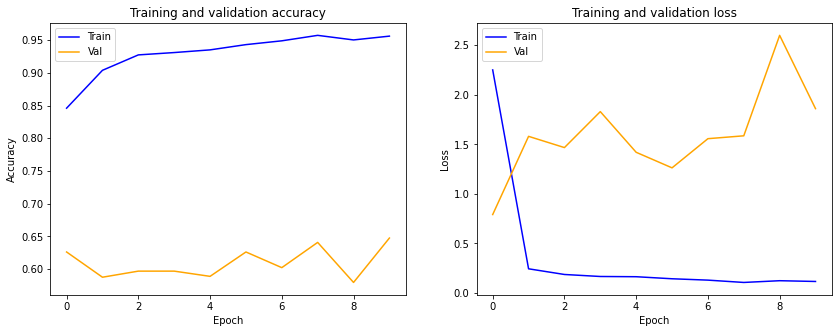

In [10]:
mdl_9_3_wo_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE,
                             validation_data =(X_valid, label_valid),  epochs=10))

In [11]:
#save_weights
mdl_9_3_wo_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da.h5/"))

del mdl_9_3_wo_ft_wo_da

### Version b: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **without** data augmentation

In [12]:
mdl_9_3_w_ft_wo_da = create_model_keras_inputs_two(fine_tune = True)
mdl_9_3_w_ft_wo_da.summary()
# display(plot_model(mdl_9_3_w_ft_wo_da))

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 299, 299, 3) 0                                            
________________________________

Epoch 1/10
184/184 [==============================] - 106s 493ms/step - loss: 0.4390 - accuracy: 0.8643 - val_loss: 13.9750 - val_accuracy: 0.5505
Epoch 2/10
184/184 [==============================] - 87s 474ms/step - loss: 0.2129 - accuracy: 0.9191 - val_loss: 1.2781 - val_accuracy: 0.6888
Epoch 3/10
184/184 [==============================] - 87s 474ms/step - loss: 0.1324 - accuracy: 0.9534 - val_loss: 1.5455 - val_accuracy: 0.6343
Epoch 4/10
184/184 [==============================] - 87s 474ms/step - loss: 0.1098 - accuracy: 0.9637 - val_loss: 1.1535 - val_accuracy: 0.6622
Epoch 5/10
184/184 [==============================] - 87s 474ms/step - loss: 0.0907 - accuracy: 0.9661 - val_loss: 4.1183 - val_accuracy: 0.5293
Epoch 6/10
184/184 [==============================] - 87s 474ms/step - loss: 0.0881 - accuracy: 0.9743 - val_loss: 1.0410 - val_accuracy: 0.7593
Epoch 7/10
184/184 [==============================] - 87s 474ms/step - loss: 0.0641 - accuracy: 0.9799 - val_loss: 1.5054 - val_

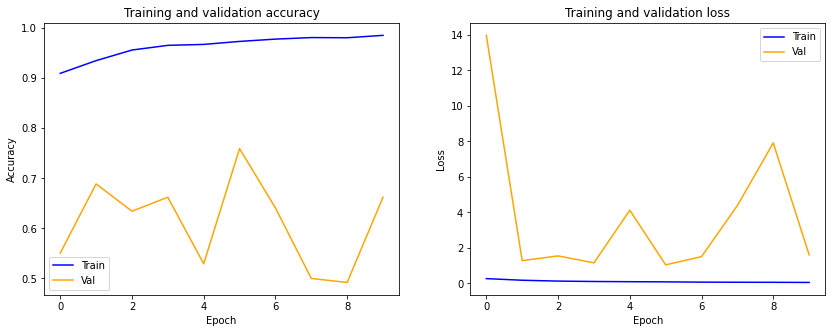

In [13]:
mdl_9_3_w_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_w_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE, 
                             validation_data =(X_valid, label_valid),  epochs=10))

In [14]:
#save_weights
mdl_9_3_w_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_wo_da.h5/"))

del mdl_9_3_w_ft_wo_da

### Version c: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **with** data augmentation

In [9]:
# Reference used to take multiple inputs for ImageData Geneartor
# https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs

gen = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2)
    # horizontal_flip = True,
    # vertical_flip = True)

gen_valid = ImageDataGenerator()

def generator_two_img(X1, X2, X3, y, batch_size):
    genX1 = gen.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = gen.flow(X2, y, batch_size=batch_size, seed=1)
    genX3 = gen.flow(X3, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        X3i = genX3.next()
        yield [X1i[0], X2i[0], X3i[0]], X1i[1]

def generator_two_img_valid(X1, X2, y, batch_size):
    genX1 = gen_valid.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = gen_valid.flow(X2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

X_train_ = generator_two_img(zoom1_train, zoom2_train, zoom3_train, label_train, 32)
X_valid_ = generator_two_img_valid(zoom1_valid, zoom2_valid, label_valid, 32)
BATCH_SIZE = 32

In [10]:
# mdl_9_3_wo_ft_w_da = create_model_keras_inputs_two(fine_tune = False)
# mdl_9_3_wo_ft_w_da.summary()
# # display(plot_model(mdl_9_3_wo_ft_w_da))

In [11]:
# mdl_9_3_wo_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

# plot(mdl_9_3_wo_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, 
#                             steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
#                             validation_data = ([zoom1_valid,zoom2_valid,zoom3_valid],label_valid), validation_steps = len(zoom1_valid)/BATCH_SIZE,
#                             shuffle=False, epochs=15))

In [12]:
# #save_weights
# mdl_9_3_wo_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_w_da.h5/"))

# del mdl_9_3_wo_ft_w_da

### Even with Google Colab Pro, it crashes due to limited RAM size

### Version d: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **with** data augmentation

In [13]:
# mdl_9_3_w_ft_w_da = create_model_keras_inputs_two(fine_tune = True)
# mdl_9_3_w_ft_w_da.summary()
# # display(plot_model(mdl_9_3_w_ft_w_da))

In [14]:
# mdl_9_3_w_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

# plot(mdl_9_3_w_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, 
#                 steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
#                 validation_data =X_valid_, validation_steps = len(zoom1_valid)/BATCH_SIZE, 
#                 shuffle=False, epochs=15))

In [15]:
# #save_weights
# mdl_9_3_w_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_w_da.h5/"))

# del mdl_9_3_w_ft_w_da

### Even with Google Colab Pro, it crashes due to limited RAM size

### Version 2.a: Batch Normalization <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normalization and extra dense layer

In [9]:
def add_layers(model, add_BN, add_Dropout):
  if add_BN:
    if add_Dropout:
      print("Added BN and Dropout")
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1, activation='sigmoid')(model)
      return model
    
    else: # i.e. only add Batch Normalization
      print("Added only BN")
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1, activation='sigmoid')(model)
      return model

    
  else: # i.e. only apply Dropout
    print("Added only Dropout")
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1024, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(128, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1, activation='sigmoid')(model)
    return model

In [10]:
# Reference used to put multiple inputs
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two_updated(fine_tune, add_BN, add_Dropout):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
    base_model_3 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()
    base_model_3 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_3 = tf.keras.Sequential([
    base_model_3,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
  input3 = Input(shape=(299,299,3))
    
  model = concatenate([model_1(input1) ,model_2(input2) ,model_3(input3)], axis =1)
  model = add_layers(model = model, add_BN = add_BN, add_Dropout = add_Dropout)
  model_final = Model(inputs=[input1,input2,input3],outputs=model)

  return model_final

87916544/87910968 [==============================] - 1s 0us/step
Added only BN
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_4[0][0]                    
_______________

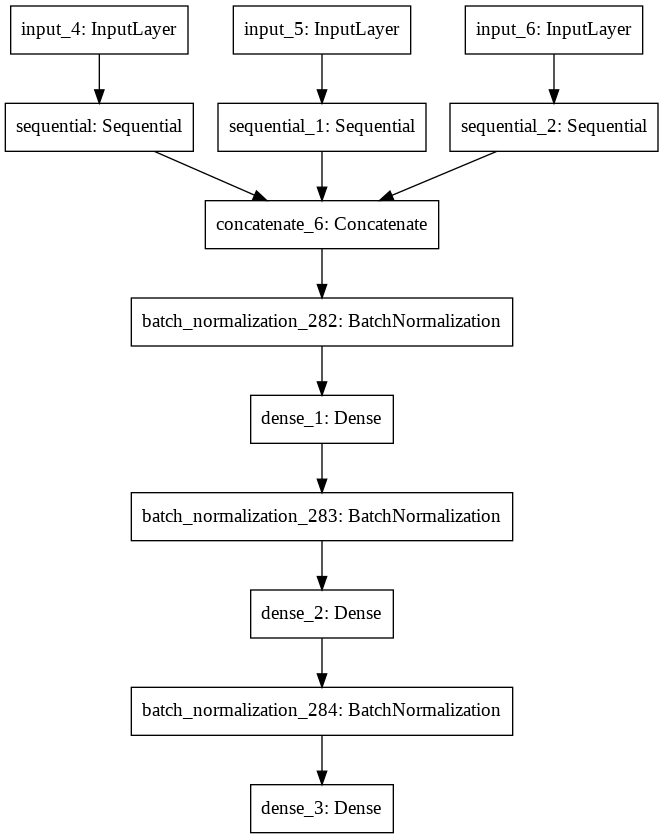

In [18]:
mdl_9_3_wo_ft_wo_da_BN = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = False)
mdl_9_3_wo_ft_wo_da_BN.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_BN))

Epoch 1/10
184/184 [==============================] - 46s 162ms/step - loss: 0.3127 - accuracy: 0.8740 - val_loss: 2.0955 - val_accuracy: 0.5293
Epoch 2/10
184/184 [==============================] - 25s 139ms/step - loss: 0.1828 - accuracy: 0.9321 - val_loss: 1.7607 - val_accuracy: 0.5359
Epoch 3/10
184/184 [==============================] - 25s 138ms/step - loss: 0.1517 - accuracy: 0.9414 - val_loss: 1.1798 - val_accuracy: 0.6383
Epoch 4/10
184/184 [==============================] - 25s 138ms/step - loss: 0.1438 - accuracy: 0.9431 - val_loss: 1.4603 - val_accuracy: 0.5279
Epoch 5/10
184/184 [==============================] - 25s 138ms/step - loss: 0.1462 - accuracy: 0.9472 - val_loss: 0.9610 - val_accuracy: 0.6955
Epoch 6/10
184/184 [==============================] - 25s 138ms/step - loss: 0.1205 - accuracy: 0.9558 - val_loss: 1.2895 - val_accuracy: 0.5798
Epoch 7/10
184/184 [==============================] - 26s 139ms/step - loss: 0.1221 - accuracy: 0.9552 - val_loss: 1.5031 - val_ac

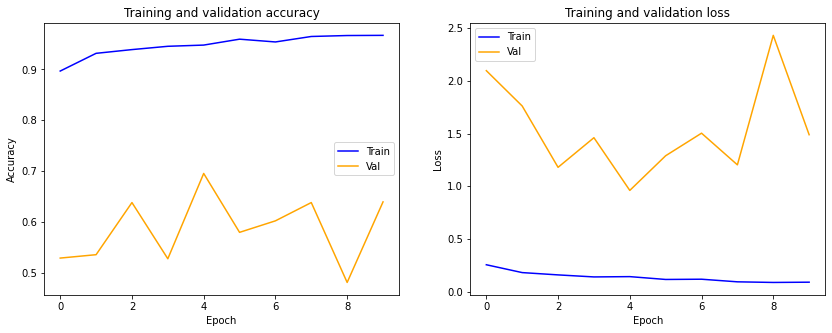

In [19]:
mdl_9_3_wo_ft_wo_da_BN.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_wo_da_BN.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [20]:
#save_weights
mdl_9_3_wo_ft_wo_da_BN.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_BN.h5/"))

del mdl_9_3_wo_ft_wo_da_BN

### Version 2.b: Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Dropout and extra dense layer

Added only Dropout
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_4[0][0]                    
___________________________________________________________________________

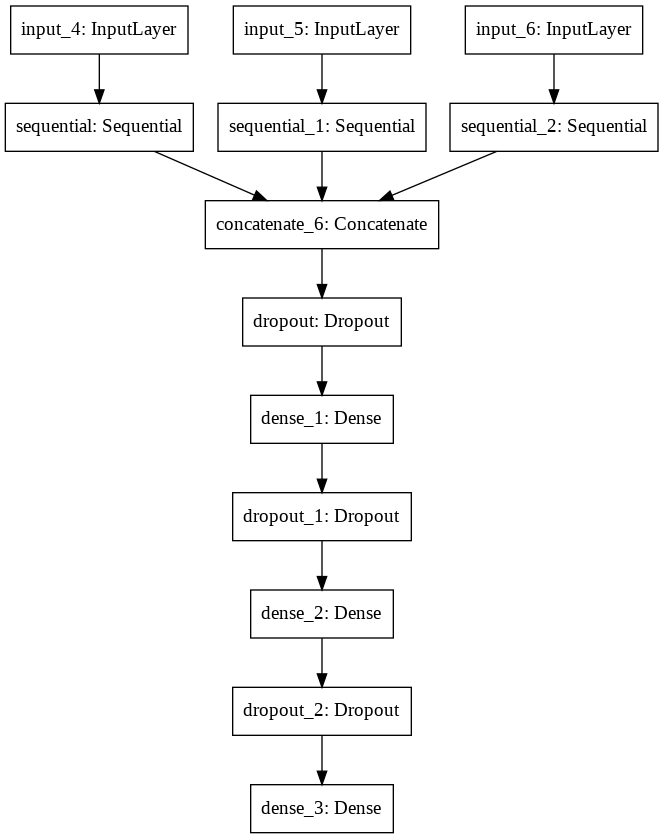

In [11]:
mdl_9_3_wo_ft_wo_da_Dropout = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = False, add_Dropout = True)
mdl_9_3_wo_ft_wo_da_Dropout.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_Dropout))

Epoch 1/10
184/184 [==============================] - 43s 159ms/step - loss: 3.1691 - accuracy: 0.7236 - val_loss: 0.6286 - val_accuracy: 0.6476
Epoch 2/10
184/184 [==============================] - 25s 136ms/step - loss: 0.3261 - accuracy: 0.8669 - val_loss: 0.6733 - val_accuracy: 0.6516
Epoch 3/10
184/184 [==============================] - 25s 135ms/step - loss: 0.2677 - accuracy: 0.8943 - val_loss: 0.8508 - val_accuracy: 0.6077
Epoch 4/10
184/184 [==============================] - 25s 135ms/step - loss: 0.2525 - accuracy: 0.8979 - val_loss: 0.8838 - val_accuracy: 0.6383
Epoch 5/10
184/184 [==============================] - 25s 135ms/step - loss: 0.2265 - accuracy: 0.9114 - val_loss: 0.9476 - val_accuracy: 0.6184
Epoch 6/10
184/184 [==============================] - 25s 135ms/step - loss: 0.2071 - accuracy: 0.9175 - val_loss: 1.0926 - val_accuracy: 0.6316
Epoch 7/10
184/184 [==============================] - 25s 135ms/step - loss: 0.2039 - accuracy: 0.9250 - val_loss: 1.3782 - val_ac

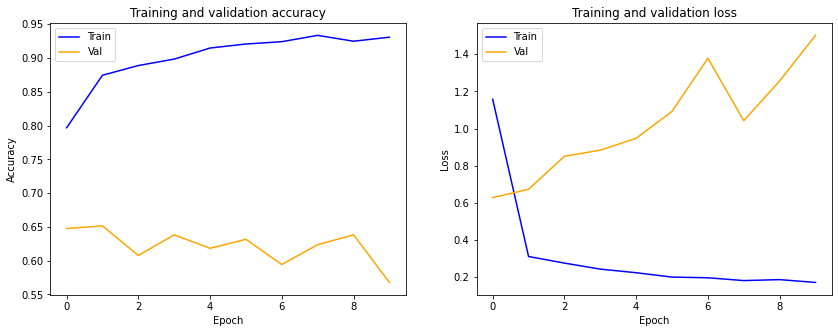

In [12]:
mdl_9_3_wo_ft_wo_da_Dropout.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])


plot(mdl_9_3_wo_ft_wo_da_Dropout.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [13]:
#save_weights
mdl_9_3_wo_ft_wo_da_Dropout.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_Dropout.h5/"))

del mdl_9_3_wo_ft_wo_da_Dropout

### Version 2.c: Batch Norm + Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normailzation, Dropout, and extra dense layer

Added BN and Dropout
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1024)         23900960    input_10[0][0]                   
_______________________________________________________________________

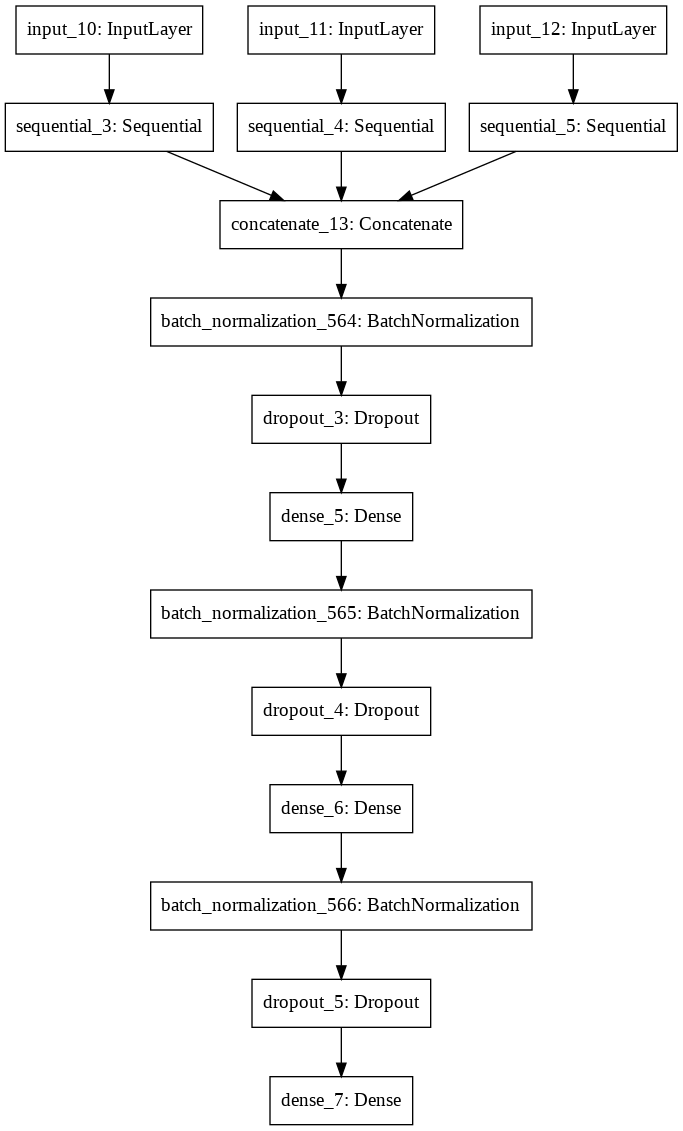

In [14]:
mdl_9_3_wo_ft_wo_da_BN_DO = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = True)
mdl_9_3_wo_ft_wo_da_BN_DO.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_BN_DO))

Epoch 1/10
184/184 [==============================] - 40s 155ms/step - loss: 0.3905 - accuracy: 0.8425 - val_loss: 1.6231 - val_accuracy: 0.5851
Epoch 2/10
184/184 [==============================] - 25s 136ms/step - loss: 0.2527 - accuracy: 0.9006 - val_loss: 2.2833 - val_accuracy: 0.5199
Epoch 3/10
184/184 [==============================] - 25s 137ms/step - loss: 0.2205 - accuracy: 0.9198 - val_loss: 1.2376 - val_accuracy: 0.6277
Epoch 4/10
184/184 [==============================] - 25s 137ms/step - loss: 0.1762 - accuracy: 0.9374 - val_loss: 1.2846 - val_accuracy: 0.6024
Epoch 5/10
184/184 [==============================] - 25s 137ms/step - loss: 0.1879 - accuracy: 0.9317 - val_loss: 1.1595 - val_accuracy: 0.5971
Epoch 6/10
184/184 [==============================] - 25s 137ms/step - loss: 0.1558 - accuracy: 0.9404 - val_loss: 1.6845 - val_accuracy: 0.5426
Epoch 7/10
184/184 [==============================] - 25s 137ms/step - loss: 0.1554 - accuracy: 0.9348 - val_loss: 1.1236 - val_ac

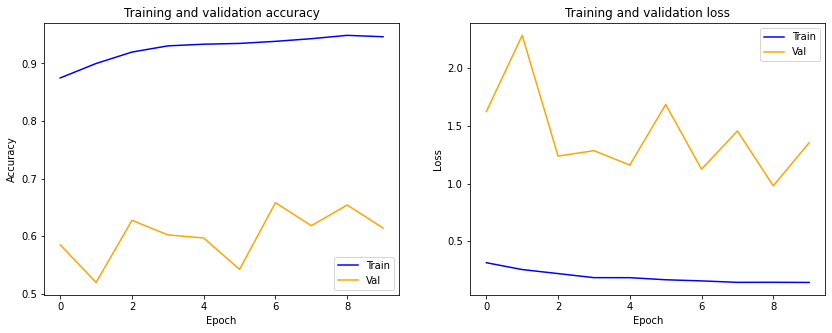

In [15]:
mdl_9_3_wo_ft_wo_da_BN_DO.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])


plot(mdl_9_3_wo_ft_wo_da_BN_DO.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [16]:
#save_weights
mdl_9_3_wo_ft_wo_da_BN_DO.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_BN_DO.h5/"))

del mdl_9_3_wo_ft_wo_da_BN_DO